In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors
from matplotlib import ticker
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator, 
                                AutoLocator, MaxNLocator)
from matplotlib import rcParams
from matplotlib import patches
import scipy.io
import astropy.constants as const
import juanfit
from juanfit import SpectrumFitSingle,SpectrumFitRow, gaussian
import copy
from scipy import interpolate
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.integrate import simps
from scipy.signal import find_peaks
rcParams['axes.linewidth'] = 1.5
import cmcrameri.cm as cmcm
import h5py
from astropy.visualization import ZScaleInterval, ImageNormalize, LogStretch, AsymmetricPercentileInterval,\
         ManualInterval, SqrtStretch
from num2tex import num2tex
from glob import glob
import os

In [2]:
path = "../../sav/AWSoM/syn_fit/box_run0026_run03_75_5th/"
with h5py.File(os.path.join(path,"FeXIV_530"+"_synspec_emiss.h5"), 'r') as hf:
    FeXIV_emiss = hf['emiss_box'][:]
with h5py.File(os.path.join(path,"FeX_637"+"_synspec_emiss.h5"), 'r') as hf:
    FeX_emiss = hf['emiss_box'][:]


In [3]:
awsom_data_set = scipy.io.readsav(r'../../sav/AWSoM/syn_fit/box_run0025_run01_75_5th/box_run0025_run01_75_5th.sav',verbose = False,python_dict=True)

m_p = const.m_p.cgs.value
k_b = const.k_B.cgs.value
c = const.c.cgs.value
rs = const.R_sun.cgs.value
amu = const.u.cgs.value

p_e_ratio = 0.83
awsom_x = awsom_data_set['x'][0,0,0,:]
awsom_y = awsom_data_set['x'][1,0,:,0]
awsom_z = awsom_data_set['x'][2,:,0,0]
awsom_x_grid = awsom_data_set['x'][0,:,:,:]
awsom_y_grid = awsom_data_set['x'][1,:,:,:]
awsom_z_grid = awsom_data_set['x'][2,:,:,:]
rho = awsom_data_set['w'][0,:,:,:]
n = rho/m_p
I01 = awsom_data_set['w'][7,:,:,:]
I02 = awsom_data_set['w'][8,:,:,:]
p = awsom_data_set['w'][9,:,:,:]
t_p = p/n/k_b
p_e = awsom_data_set['w'][10,:,:,:]
t_e = p_e/n/k_b
p_par = awsom_data_set['w'][11,:,:,:]
t_par = p_par/n/k_b
t_perp = (3*t_p - t_par)/2.

rot_DD = np.resize(awsom_data_set["param"],(3,3))
b_vec = awsom_data_set['w'][4:7,:,:,:]
b_tot = np.sqrt(np.sum(np.square(b_vec),axis=0))
u_vec = awsom_data_set['w'][1:4,:,:,:]
u_tot = np.sqrt(np.sum(np.square(u_vec),axis=0))
bx_rot, by_rot, bz_rot = np.einsum('ij,jklm->iklm',rot_DD,b_vec)
ux_rot, uy_rot, uz_rot = np.einsum('ij,jklm->iklm',rot_DD,u_vec)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


In [4]:
cos_alpha = bx_rot/b_tot
sin_alpha = np.sqrt(1 - cos_alpha**2)

vnt2 = 0.5*(I01 + I02)/m_p/n*sin_alpha**2 
tlos = t_perp*sin_alpha**2 + t_par*cos_alpha**2

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [5]:
def plot_colorbar(im, ax, width="3%", height="100%",loc="lower left",fontsize=14):
    clb_ax = inset_axes(ax,width=width,height=height,loc=loc,
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0)
    clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax,cax=clb_ax)
    clb_ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    clb_ax.yaxis.get_offset_text().set_fontsize(fontsize)
    clb_ax.tick_params(labelsize=fontsize)
    return clb, clb_ax

In [6]:
np.where(awsom_y == -1.1) 

(array([37]),)

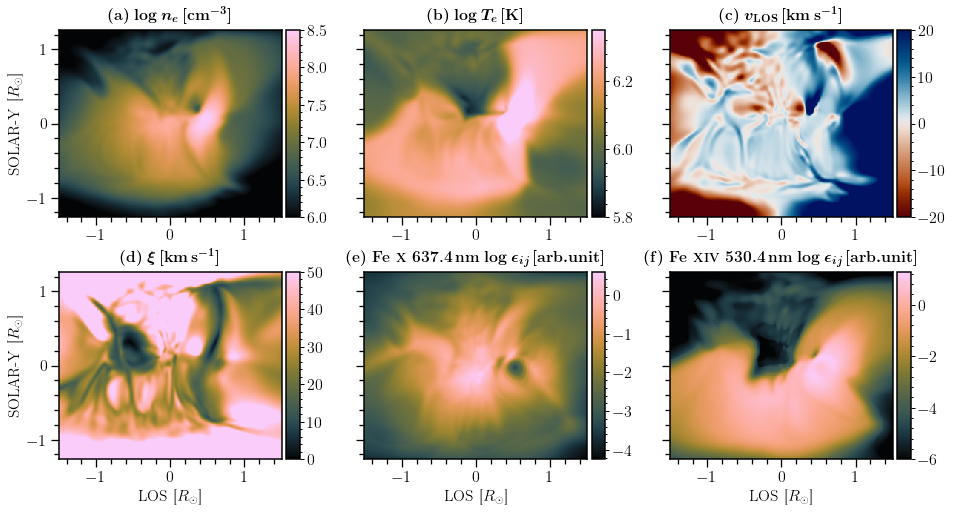

In [7]:
fig, axes = plt.subplots(2,3,figsize=(13,7),constrained_layout=True)

ycut_index = 37

im00 = axes[0,0].pcolormesh(awsom_x,awsom_z,np.log10(n[:,ycut_index,:]/p_e_ratio),rasterized=True,cmap=cmcm.batlowK,
                        shading='auto',vmax=8.5,vmin=6)
plot_colorbar(im00,ax=axes[0,0],width="6%",fontsize=16)
axes[0,0].set_title(r'\textbf{(a)} $\boldsymbol{\log n_e\,\mathrm{[cm^{-3}]}}$',
                    fontsize=16,pad=10)

# im01 = axes[0,1].pcolormesh(awsom_x,awsom_z,np.log10(t_p[:,ycut_index,:]),rasterized=True,cmap=cmcm.batlowK,
#                         shading='auto',vmin=5.8,vmax=6.35)
# plot_colorbar(im01,ax=axes[0,1],width="6%",fontsize=16)
# axes[0,1].set_title(r'\textbf{(b)} $\boldsymbol{\log T_p\,\mathrm{[K]}}$',
#                     fontsize=16,pad=10)

im01 = axes[0,1].pcolormesh(awsom_x,awsom_z,np.log10(t_e[:,ycut_index,:]),rasterized=True,cmap=cmcm.batlowK,
                        shading='auto',vmin=5.8,vmax=6.35)
plot_colorbar(im01,ax=axes[0,1],width="6%",fontsize=16)
axes[0,1].set_title(r'\textbf{(b)} $\boldsymbol{\log T_e\,\mathrm{[K]}}$',
                    fontsize=16,pad=10)

im02 = axes[0,2].pcolormesh(awsom_x,awsom_z,ux_rot[:,ycut_index,:],rasterized=True,cmap=cmcm.vik_r,
                        shading='auto',vmin=-20,vmax=20)
plot_colorbar(im02,ax=axes[0,2],width="6%",fontsize=16)
axes[0,2].set_title(r'\textbf{(c)} $\boldsymbol{v_{\rm LOS}\,[\mathrm{km\, s^{-1}}]}$',
                    fontsize=16,pad=10)

im10 = axes[1,0].pcolormesh(awsom_x,awsom_z,np.sqrt(vnt2[:,ycut_index,:])/1e5,rasterized=True,cmap=cmcm.batlowK,
                        shading='auto',vmin=0,vmax=50)
plot_colorbar(im10,ax=axes[1,0],width="6%",fontsize=16)
axes[1,0].set_title(r'\textbf{(d)} $\boldsymbol{\xi\,\mathrm{[km\,s^{-1}]}}$',
                    fontsize=16,pad=10)

im11 = axes[1,1].pcolormesh(awsom_x,awsom_z,np.log10(FeX_emiss[:,ycut_index,:]),rasterized=True,cmap=cmcm.batlowK,
                        shading='auto')
plot_colorbar(im11,ax=axes[1,1],width="6%",fontsize=16)
axes[1,1].set_title(r'\textbf{(e) Fe \textsc{x} 637.4\,nm} $\boldsymbol{\log \epsilon_{ij}\,\mathrm{[arb.unit]}}$',
                    fontsize=16,pad=10)

im12 = axes[1,2].pcolormesh(awsom_x,awsom_z,np.log10(FeXIV_emiss[:,ycut_index,:]),rasterized=True,cmap=cmcm.batlowK,
                        shading='auto',vmin=-6)
plot_colorbar(im12,ax=axes[1,2],width="6%",fontsize=16)
axes[1,2].set_title(r'\textbf{(f) Fe \textsc{xiv} 530.4\,nm} $\boldsymbol{\log \epsilon_{ij}\,\mathrm{[arb.unit]}}$',
                    fontsize=16,pad=10)

for ax_ in axes.flatten():
    ax_.axis('scaled')
    # ax_.set_ylabel(r'Slit $[R_\odot]$',fontsize=18)
    # ax_.yaxis.set_major_locator(MultipleLocator(0.2))
    ax_.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax_.yaxis.set_minor_locator(AutoMinorLocator(5))
    ax_.tick_params(which="major",width=1.3,length=8)
    ax_.tick_params(which="minor",width=1.3,length=5)
    ax_.tick_params(labelsize=16)

for ii in range(2):
    for jj in range(3):
        if jj in (1,2):
            axes[ii,jj].tick_params(labelleft=False)
        if jj == 0:
            axes[ii,jj].set_ylabel("SOLAR-Y [$R_\odot$]",fontsize=16)
        if ii == 1:
            axes[ii,jj].set_xlabel("LOS [$R_\odot$]",fontsize=16)

# plt.savefig("../../sav/AWSoM/syn_fit/box_run0023_run03_75_5th/AWSoM_y=-1.1.pdf",format="pdf",bbox_inches="tight")
# fig.suptitle("$\mathrm{SOLAR-Y}=-1.1\,R_\odot$",fontsize=18)